# MNE Library fNIRS Data PreProcess

## Useful Resources

- [NIRx - Webinar Archive](https://nirx.net/webinars)
  - Video Webinar
    - [An introduction to fNIRS analysis using MNE with Dr. Robert Luke Part 1](https://www.youtube.com/watch?v=qfWwyS00Xh0)
    - [Simplifying machine learning for fNIRS: implementation and benchmarking with BenchNIRS](https://www.youtube.com/watch?v=zJfRhJ04cu4)
- Environment Setup
  - [mne-library-advanced-setup](https://mne.tools/stable/install/advanced.html)
    - Step 1: `pip cache purge` (not-always)
    - Step 2: `conda install --name=base nb_conda_kernels`
    - Step 3: `pip install "mne[full]" `
    - Step 4: `conda install cupy`

## Import Library

In [1]:
from itertools import compress
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# %matplotlib qt
%matplotlib inline

import mne
import mne_nirs

mne.viz.set_3d_backend("notebook")
mne.utils.set_config('MNE_USE_CUDA', 'true')  

CURRENT_DIR = os.getcwd()
DATA_DIR = os.path.join(CURRENT_DIR, 'data_NIRS_Experiment')

# Create directory if it does not exist
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

Using notebook 3d backend.


## 1. Raw Data Understanding

- `raw_intensity` metadata:
  - **General**
    - `Filename` = `2023-12-05_004`
    - `MNE object type` = `RawNIRX`
    - `Measurement date` = `2023-12-05 at 14:05:14 UTC`
  - **Acquisition**
    - `Duration` = `00:15:28 (HH:MM:SS)`
    - `Sampling Frequency` = `10.17 Hz`
    - `Time Points` = `9346`
  - **Channels**
    - `fNIRS (CW amplitude)` = `46`
    - `Head & sensor digitization` = `26 points`
  - **Filters**
    - `Highpass` = `0.00 Hz`
    - `Lowpass` = `5.09 Hz`
- `raw_intensity` keys:
  - `dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])`

### 1. Import RAW Data

In [2]:
# Get path for just the first participant
raw_fname = f'{DATA_DIR}/2023-12-05_004'
fname_snirf = f'{raw_fname}/2023-12-05_004.snirf'

# Load the NIRx data
raw_intensity = mne.io.read_raw_nirx(raw_fname, preload=True)
data = mne.io.read_raw_snirf(fname_snirf, preload=True)

# Querying raw data info
info = raw_intensity.info
print(f"Channels Names: {info['ch_names']}")
print(f"Number of Channels: {info['nchan']}")
print(f"Sampling Frequency: {info['sfreq']} Hz")
print(info['chs'][0]['loc'])

Loading d:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\36. FNIRS-Anxiety\CODE\3. fNIRS\PYTHON\notebook\data_NIRS_Experiment/2023-12-05_004


C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_18664\1962790026.py:6: RuntimeWarning: MNE has not been tested with Aurora version 2021.9.0-20-g15526401-dirty
  raw_intensity = mne.io.read_raw_nirx(raw_fname, preload=True)


Reading 0 ... 9435  =      0.000 ...   927.498 secs...
Loading d:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\36. FNIRS-Anxiety\CODE\3. fNIRS\PYTHON\notebook\data_NIRS_Experiment\2023-12-05_004\2023-12-05_004.snirf
Reading 0 ... 9435  =      0.000 ...   927.460 secs...
Channels Names: ['S1_D1 760', 'S1_D1 850', 'S1_D3 760', 'S1_D3 850', 'S2_D2 760', 'S2_D2 850', 'S2_D1 760', 'S2_D1 850', 'S2_D5 760', 'S2_D5 850', 'S3_D1 760', 'S3_D1 850', 'S3_D3 760', 'S3_D3 850', 'S3_D4 760', 'S3_D4 850', 'S3_D6 760', 'S3_D6 850', 'S4_D4 760', 'S4_D4 850', 'S4_D5 760', 'S4_D5 850', 'S4_D7 760', 'S4_D7 850', 'S5_D2 760', 'S5_D2 850', 'S5_D5 760', 'S5_D5 850', 'S5_D8 760', 'S5_D8 850', 'S6_D3 760', 'S6_D3 850', 'S6_D6 760', 'S6_D6 850', 'S7_D4 760', 'S7_D4 850', 'S7_D6 760', 'S7_D6 850', 'S7_D7 760', 'S7_D7 850', 'S8_D5 760', 'S8_D5 850', 'S8_D7 760', 'S8_D7 850', 'S8_D8 760', 'S8_D8 850']
Number of Channels: 46
Sampling Frequency: 10.172526041666666 Hz
[-2.27674624e-02  1.17079680e-01  3.28281

### 2. View RAW Data

##### 1. Channel Montage Plot

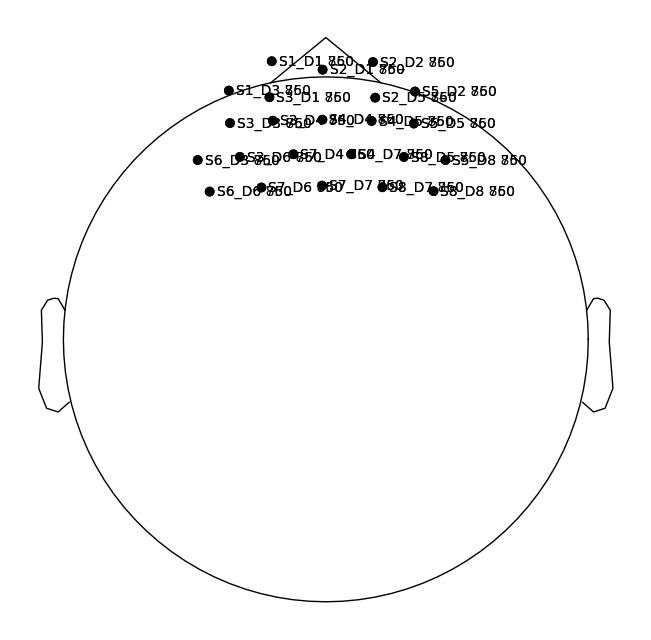

In [23]:
fig = raw_intensity.plot_sensors(show_names=True, show=False)


##### 2. Time Marker Plot

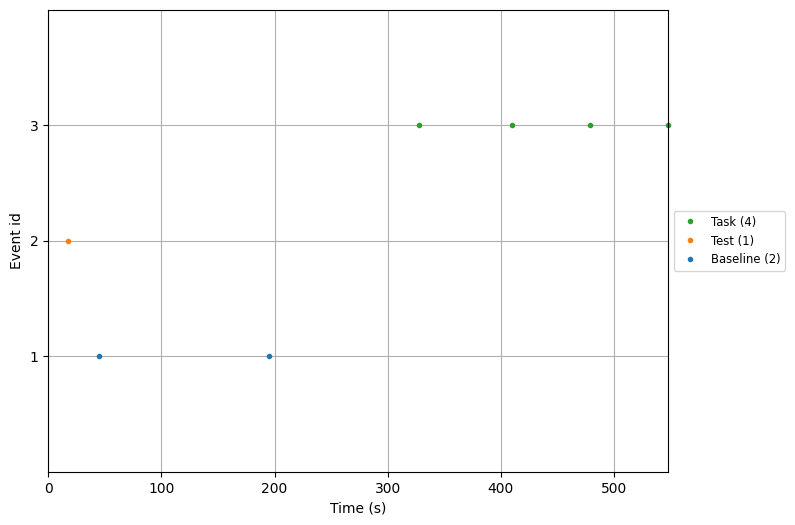

In [402]:
events, event_dict = mne.events_from_annotations(raw_intensity, verbose=False)
event_dict = {'Baseline': 1, 'Test': 2, 'Task': 3}

plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_intensity.info['sfreq']);

##### 3. Interactive Source-Detector Plot Given Duration

In [403]:
plt.rcParams["figure.figsize"] = (10, 10) # (w, h)
raw_intensity.plot(duration=600, n_channels=len(raw_intensity.ch_names));

  1%|2                                | 13.1M/1.65G [53:05<110:46:16, 4.11kB/s]


## 2. Follow `mne-tools` Example

- No channels mark as bad (`channels < 0.01`)

In [404]:
picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True) # fNIRS Channel 0 - 45 channels

# We want to remove channels that are too close together (short channels)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks=picks
)

raw_intensity.pick(picks[dists > 0.01]) 

print(f"Distance between sources and detectors: {dists}")

raw_intensity.plot(
    n_channels=len(raw_intensity.ch_names), duration=500, show_scrollbars=False
)

Distance between sources and detectors: [0.02931522 0.02931522 0.04228823 0.04228823 0.02893175 0.02893175
 0.02685601 0.02685601 0.03735531 0.03735531 0.03769049 0.03769049
 0.02570196 0.02570196 0.02584687 0.02584687 0.03769654 0.03769654
 0.02534412 0.02534412 0.02557575 0.02557575 0.03957116 0.03957116
 0.04188172 0.04188172 0.0255131  0.0255131  0.03457663 0.03457663
 0.03514837 0.03514837 0.0342502  0.0342502  0.03969167 0.03969167
 0.03437074 0.03437074 0.03393907 0.03393907 0.03728377 0.03728377
 0.03415444 0.03415444 0.03412505 0.03412505]
Channels marked as bad:
none


In [405]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
print(dir(raw_od))
# raw_od.plot(n_channels=len(raw_od.ch_names), duration=500, show_scrollbars=False)

['__class__', '__contains__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_cals', '_check_bad_segment', '_comp', '_cropped_samp', '_data', '_dtype', '_dtype_', '_extra_attributes', '_filenames', '_first_samps', '_first_time', '_get_buffer_size', '_get_channel_positions', '_getitem', '_handle_tmin_tmax', '_init_kwargs', '_last_samps', '_last_time', '_orig_units', '_parse_get_set_params', '_pick_drop_channels', '_pick_projs', '_preload_data', '_projector', '_raw_extras', '_raw_lengths', '_read_comp_grade', '_read_picks', '_read_segment', '_read_segment_file', '_reconstruct_proj', '_repr_html_', '_

[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

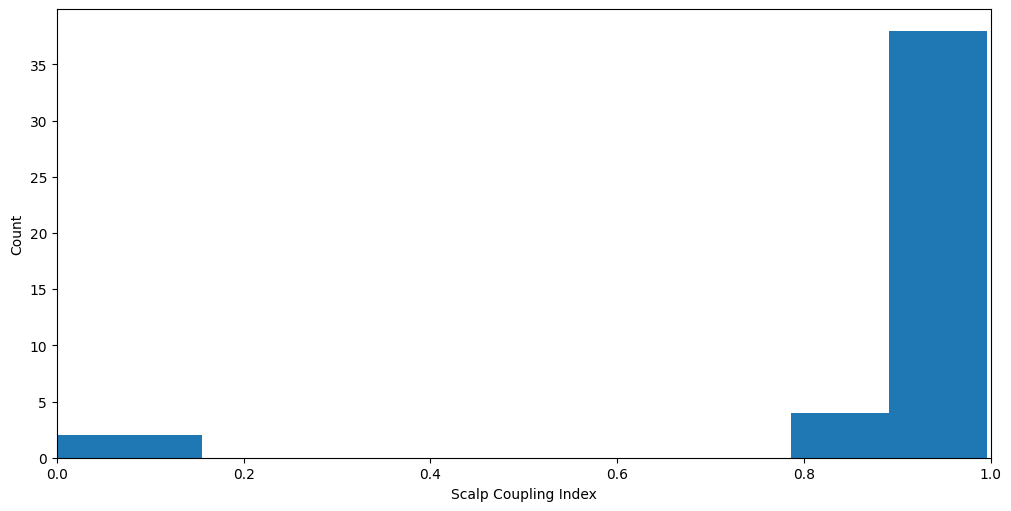

In [406]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))
ax.hist(sci)
ax.set(xlabel="Scalp Coupling Index", ylabel="Count", xlim=[0, 1])

In [407]:
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
raw_od.plot(n_channels=len(raw_od.ch_names), duration=500, show_scrollbars=False)

Channels marked as bad:
none


In [408]:
raw_od_unfiltered = raw_od.copy()
raw_od.filter(l_freq=0.001, h_freq=0.1)
# for when, _raw in dict(Before=raw_od_unfiltered, After=raw_od).items():
#     fig = _raw.compute_psd().plot(
#         average=True, amplitude=False, picks="data", exclude="bads"
#     )
#     fig.suptitle(f"{when} filtering", weight="bold", size="x-large")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.001 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.00
- Lower transition bandwidth: 0.00 Hz (-6 dB cutoff frequency: 0.00 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 33571 samples (3300.164 s)



C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_21724\3198731873.py:2: RuntimeWarning: filter_length (33571) is longer than the signal (9436), distortion is likely. Reduce filter length or filter a longer signal.
  raw_od.filter(l_freq=0.001, h_freq=0.1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawNIRX | 2023-12-05_004, 46 x 9436 (927.5 s), ~3.4 MB, data loaded>

In [409]:
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=500, show_scrollbars=False)

Used Annotations descriptions: ['1.0', '2.0', '3.0']


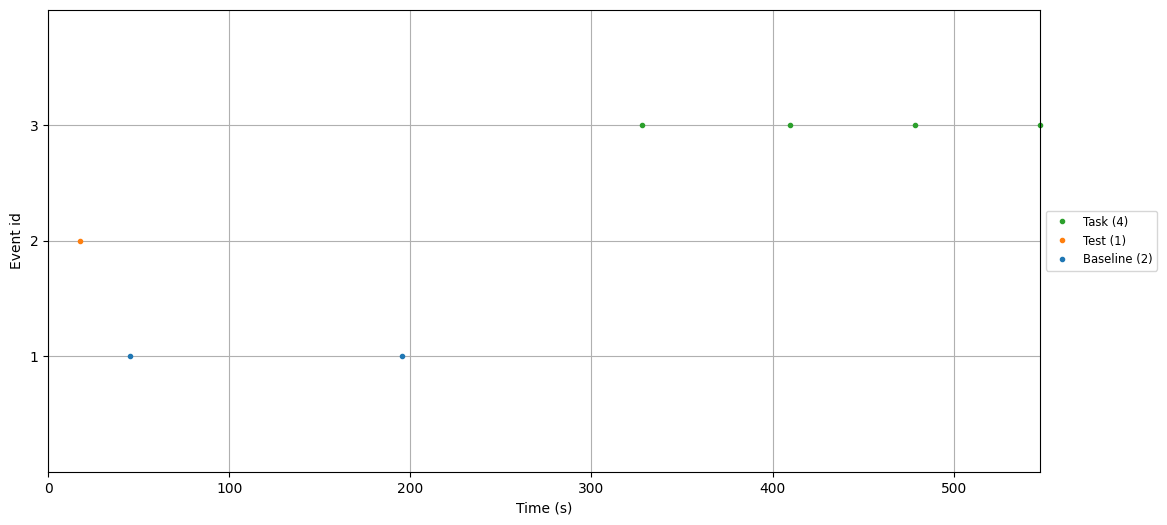

In [410]:
events, event_dict = mne.events_from_annotations(raw_haemo)
event_dict = {'Baseline': 1, 'Test': 2, 'Task': 3}
plt.rcParams['figure.figsize'] = (16, 6) # (w, h)
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info["sfreq"])

## 3. Waveform Analysis | Preprocessing Pipeline

#### 1. Preprocessing Pipeline

In [435]:
raw_intensity = mne.io.read_raw_nirx(raw_fname, preload=True, verbose=False)
raw_intensity

C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_21724\1792188526.py:1: RuntimeWarning: MNE has not been tested with Aurora version 2021.9.0-20-g15526401-dirty
  raw_intensity = mne.io.read_raw_nirx(raw_fname, preload=True, verbose=False)


<RawNIRX | 2023-12-05_004, 46 x 9436 (927.5 s), ~3.4 MB, data loaded>

In [436]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

# Calculate the sci index
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))

raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)
good_channels_idx = mne.pick_channels(raw_haemo.ch_names, raw_haemo.info["ch_names"], exclude=raw_haemo.info["bads"])
raw_haemo.pick(good_channels_idx)

<RawNIRX | 2023-12-05_004, 42 x 9436 (927.5 s), ~3.1 MB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 201.327 (s)
Plotting power spectral density (dB=True).


c:\ProgramData\miniconda3\envs\fnirs\lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


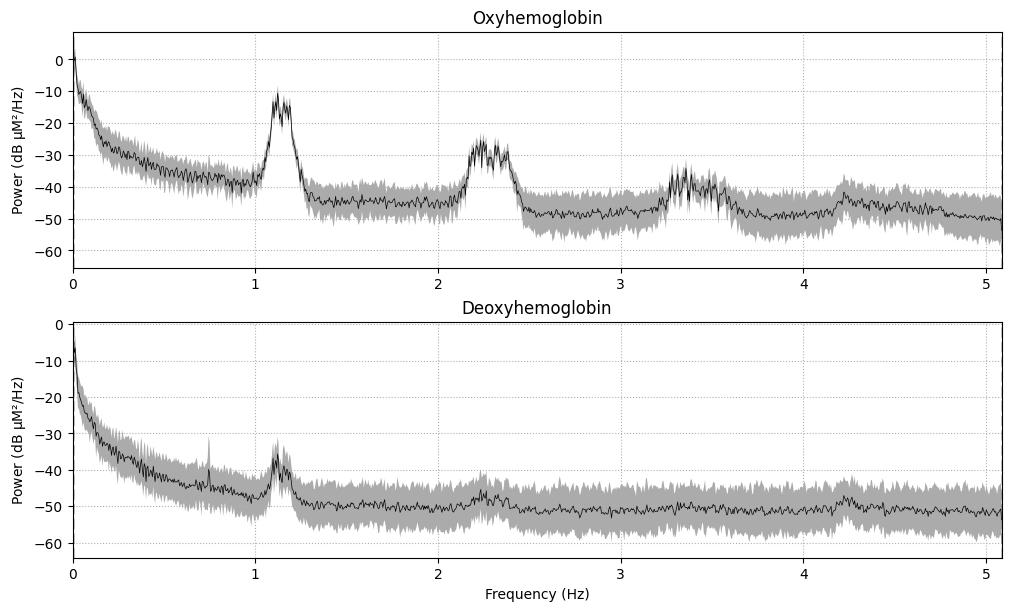

In [437]:
raw_haemo.plot_psd(average=True);

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 201.327 (s)


Plotting power spectral density (dB=True).


c:\ProgramData\miniconda3\envs\fnirs\lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


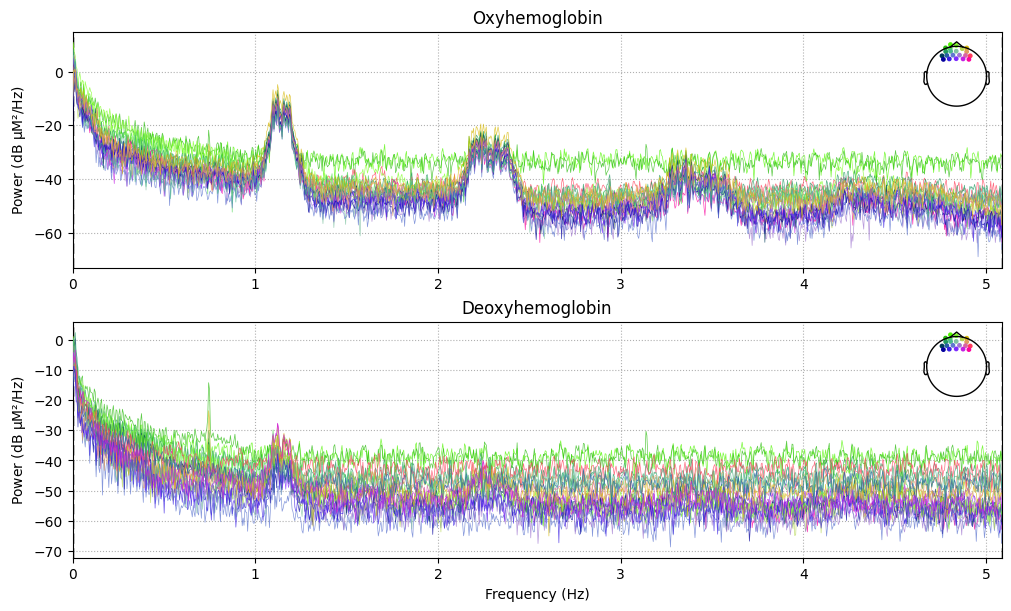

In [438]:
plt.rcParams["figure.figsize"] = (16, 14) # (w, h)
raw_haemo.plot_psd(average=False);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.001 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.00
- Lower transition bandwidth: 0.00 Hz (-6 dB cutoff frequency: 0.00 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 33571 samples (3300.164 s)



C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_21724\3666132850.py:8: RuntimeWarning: filter_length (33571) is longer than the signal (9436), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo_filtered.filter(l_freq=l_freq, h_freq=h_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 201.327 (s)
Plotting power spectral density (dB=True).
Effective window size : 201.327 (s)
Plotting power spectral density (dB=True).


c:\ProgramData\miniconda3\envs\fnirs\lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
c:\ProgramData\miniconda3\envs\fnirs\lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


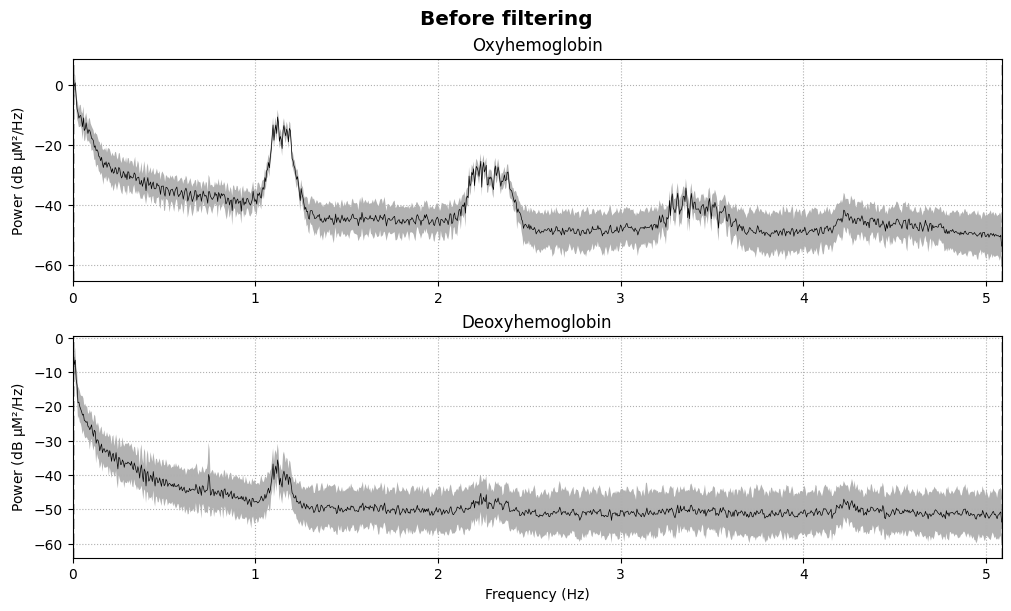

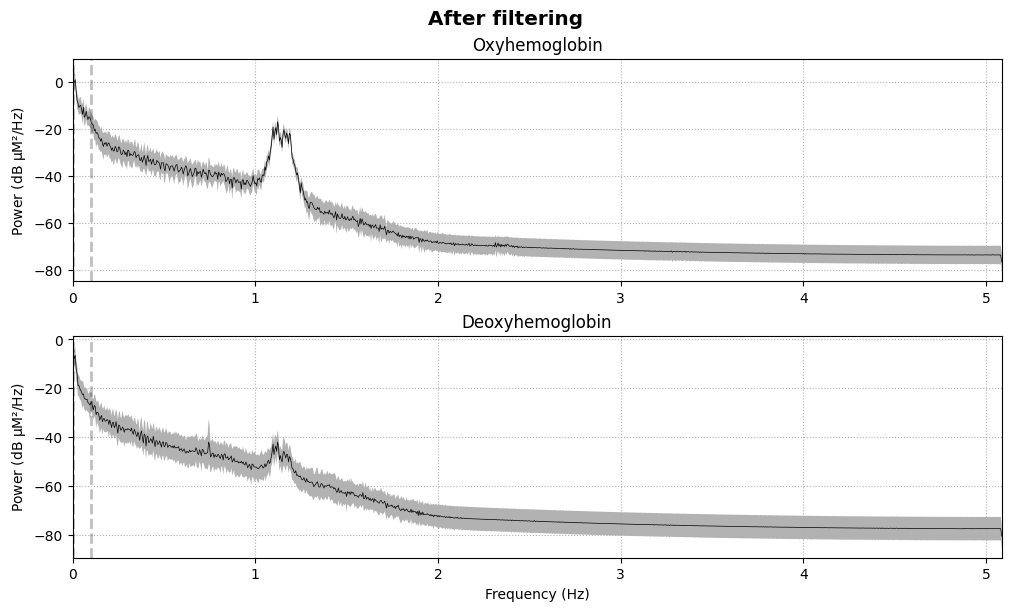

In [439]:
l_freq = 0.001
h_freq = 0.1
l_trans_bandwidth = 0.02
h_trans_bandwidth = 0.001

# Now apply the filter to a NEW copy to keep the original untouched
raw_haemo_filtered = raw_haemo.copy()
raw_haemo_filtered.filter(l_freq=l_freq, h_freq=h_freq)

# Plot both the unfiltered and filtered data
for when, _raw in dict(Before=raw_haemo, After=raw_haemo_filtered).items():
    fig = _raw.compute_psd().plot(
        average=True, amplitude=False, picks="data", exclude="bads"
    )
    fig.suptitle(f"{when} filtering", weight="bold", size="x-large")

In [209]:
help(raw_haemo_filtered.to_data_frame)

Help on method to_data_frame in module mne.io.base:

to_data_frame(picks=None, index=None, scalings=None, copy=True, start=None, stop=None, long_format=False, time_format=None, *, verbose=None) method of mne.io.nirx.nirx.RawNIRX instance
    Export data in tabular structure as a pandas DataFrame.
    
    Channels are converted to columns in the DataFrame. By default, an
    additional column "time" is added, unless ``index`` is not ``None``
    (in which case time values form the DataFrame's index).
    
    Parameters
    ----------
    picks : str | array-like | slice | None
        Channels to include. Slices and lists of integers will be interpreted as 
        channel indices. In lists, channel *type* strings (e.g., ``['meg', 
        'eeg']``) will pick channels of those types, channel *name* strings (e.g., 
        ``['MEG0111', 'MEG2623']`` will pick the given channels. Can also be the 
        string values ``'all'`` to pick all channels, or ``'data'`` to pick 
        :term:

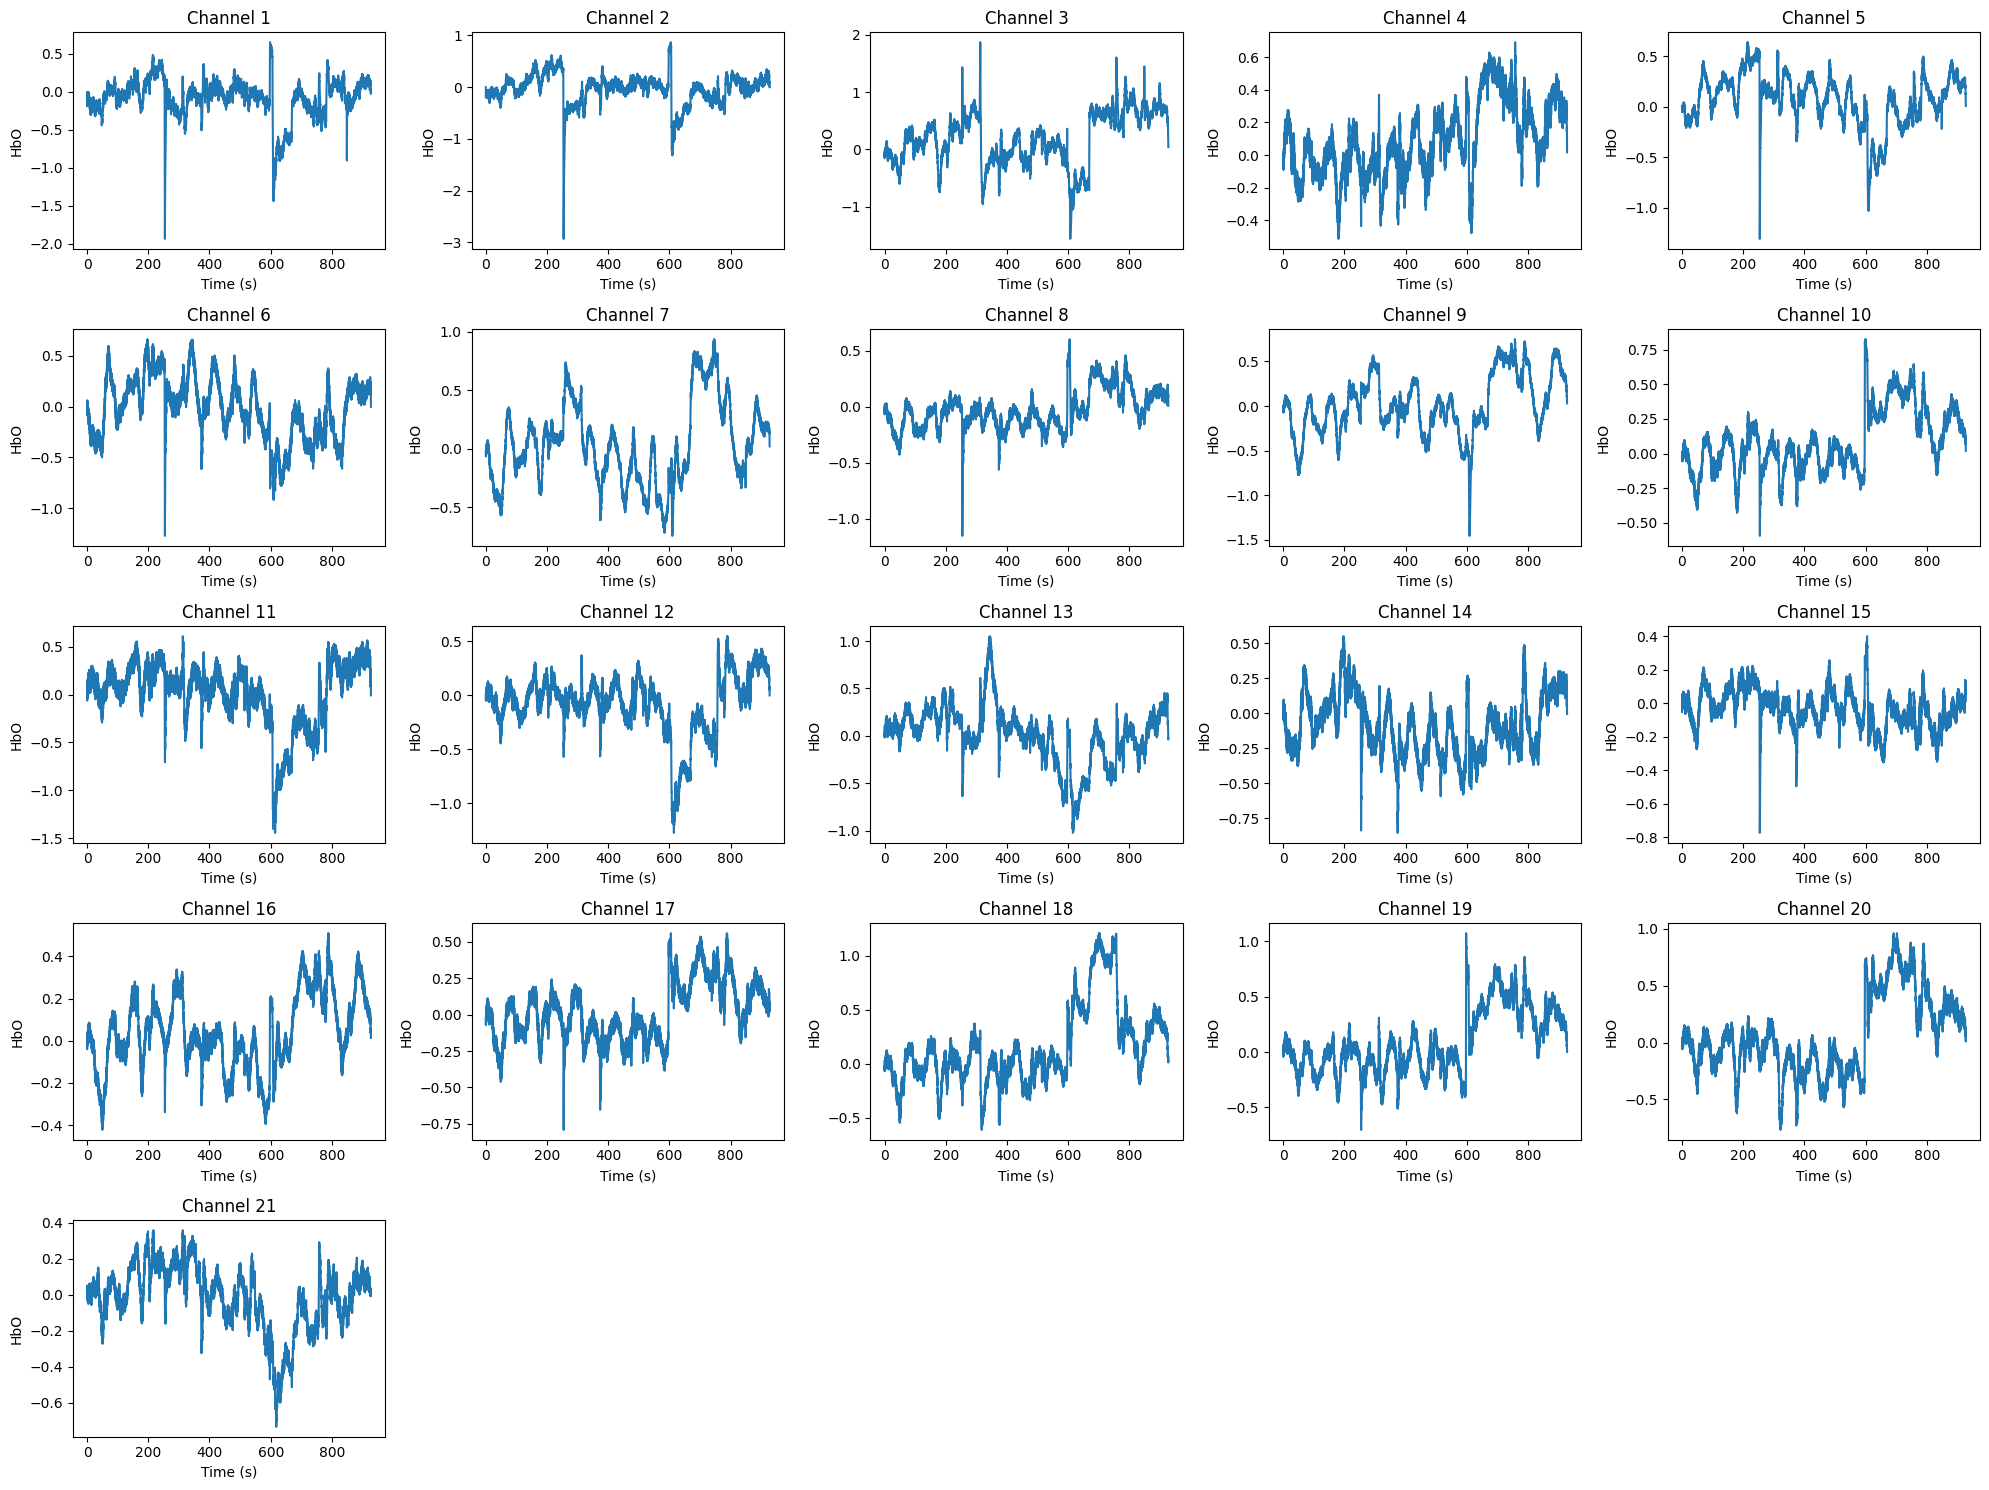

In [440]:
df = raw_haemo_filtered.to_data_frame()

time = df.iloc[:, 0]
HbO = df.iloc[:, 1::2] # (23, time_samples)
HbR = df.iloc[:, 2::2] # (23, time_samples)

# plt.plot(time, HbO.iloc[:, index_S4_D5], label="S2_D2")

# Assume HbO_T is transposed already: (time_samples, 23 channels)
num_channels = HbO.shape[1]  # number of channels

# Set up the figure with 5 rows and 5 columns for subplots (total 25 subplots)
fig, axes = plt.subplots(5, 5, figsize=(20, 15))  # 5 rows, 5 columns

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate over the channels
for i in range(num_channels):
    ax = axes[i]
    ax.plot(time, HbO.T.iloc[i, :])  # Plot HbO data against time
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('HbO')

# Hide any extra subplots (24th and 25th) that are unused
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

Used Annotations descriptions: ['1.0', '2.0', '3.0']


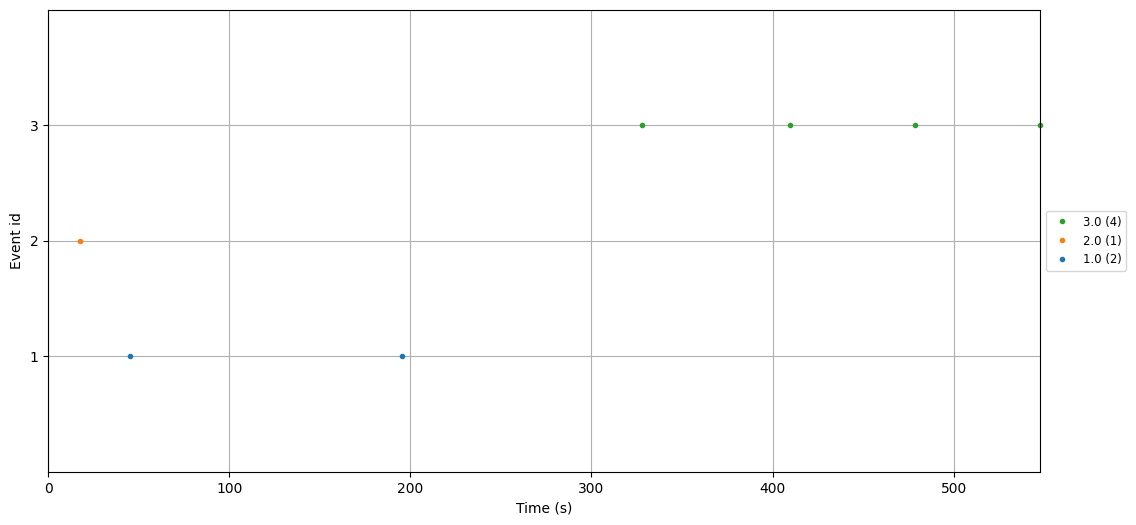

In [441]:
events, event_id = mne.events_from_annotations(raw_haemo)
# event_id = {'Baseline': 1, 'Test': 2, 'Task': 3}

plt.rcParams['figure.figsize'] = (16, 6) # (w, h)

fig = mne.viz.plot_events(events, event_id=event_id, sfreq=raw_haemo.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

In [442]:
tmin, tmax = -5, 35 # Start of epoch at 0, go up to 35s
baseline = None     # No baseline correction
event_id = {'Baseline': 1, 'Test': 2, 'GNG': 3}

reject_criteria = dict(hbo=80e-6)

epochs = mne.Epochs(raw_haemo_filtered, events, event_id, 
                    tmin=tmin, tmax=tmax, baseline=baseline, preload=True,
                    reject=reject_criteria, reject_by_annotation=True)
epochs

Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 7 events and 408 original time points ...
0 bad epochs dropped


<Epochs | 7 events (all good), -5.014 – 34.996 s (baseline off), ~993 kB, data loaded,
 'Baseline': 2
 'Test': 1
 'GNG': 4>

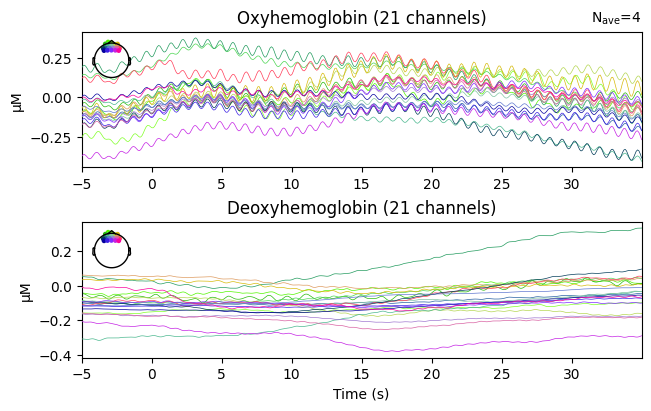

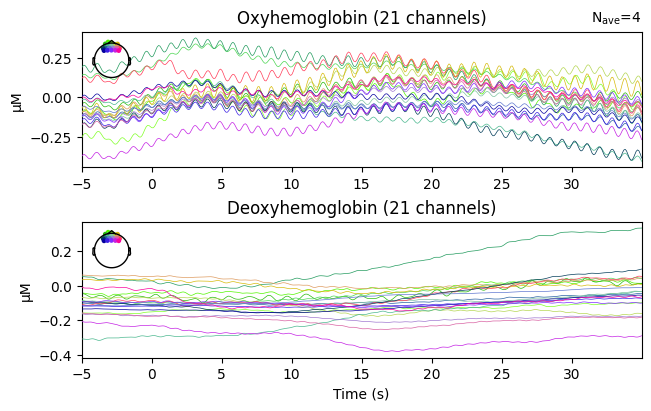

In [443]:
epochs['GNG'].average().plot()

No projector specified for this dataset. Please consider the method self.add_proj.


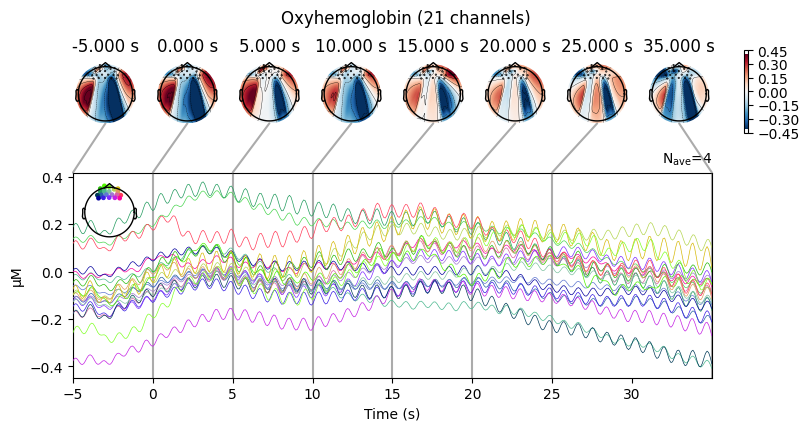

In [444]:
evoked = epochs['GNG'].average()
evoked.pick(picks='hbo').plot_joint(times=[-5, 0, 5, 10, 15, 20, 25, 35], topomap_args=dict(extrapolate='head'));

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


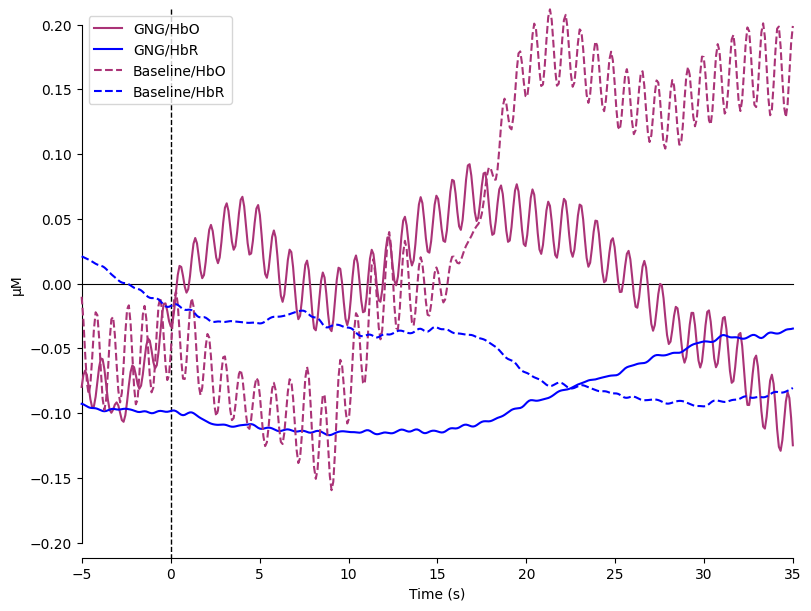

[<Figure size 800x600 with 1 Axes>]

In [445]:
evoked_dict = {
    "GNG/HbO": epochs["GNG"].average().pick(picks="hbo"),
    "GNG/HbR": epochs["GNG"].average().pick(picks="hbr"),
    "Baseline/HbO": epochs["Baseline"].average().pick(picks="hbo"),
    "Baseline/HbR": epochs["Baseline"].average().pick(picks="hbr"),
}

for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO="#AA3377", HbR="b")
styles_dict = dict(Baseline=dict(linestyle="dashed"))

mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)

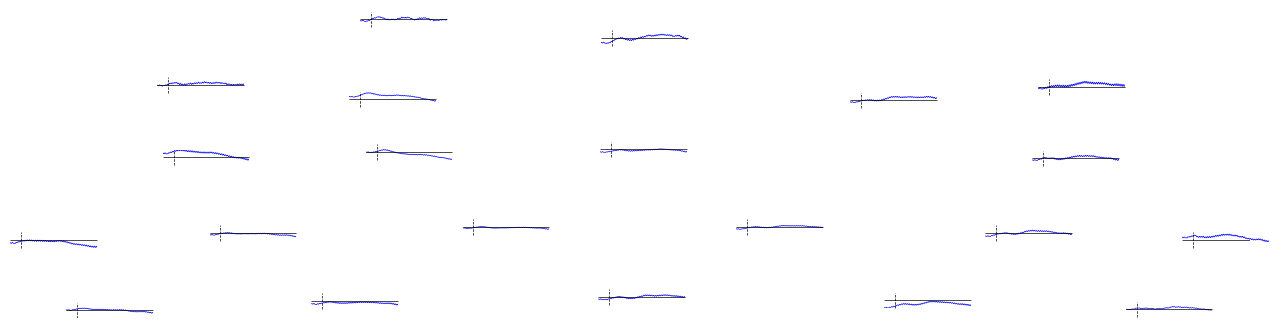

In [446]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
mne.viz.plot_evoked_topo(
    epochs['GNG'].average().pick(picks='hbo'), color='b', axes=axes, legend=False
)
mne.viz.plot_evoked_topo(
    epochs['GNG'].average().pick(picks='hbr'), color='r', axes=axes, legend=False
)

leg_lines = [line for line in axes.lines if line.get_c() == "b"][:1]
leg_lines.append([line for line in axes.lines if line.get_c() == "r"][0])
fig.legend(leg_lines, ["Left", "Right"], loc="lower right")

#### 2. BIDS Dataset Structures

In [394]:
import os.path as op
import pathlib
import shutil

import mne
from mne_nirs import datasets  # For convenient downloading of example data

from mne_bids import BIDSPath, print_dir_tree, write_raw_bids
from mne_bids.stats import count_events

raw = mne.io.read_raw_snirf(fname=fname_snirf, preload=False, verbose=False)
trigger_info = {"1": "Baseline", "2": "Test", "3": "Task"}
raw.annotations.rename(trigger_info)

subject_id = "01"
task = "GNG"
bids_root = os.path.join(DATA_DIR, "BIDS")
if op.exists(bids_root):
    shutil.rmtree(bids_root)

bids_path = BIDSPath(subject=subject_id, task=task, root=bids_root)
write_raw_bids(raw, bids_path, overwrite=True)

Writing 'd:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\36. FNIRS-Anxiety\CODE\3. fNIRS\PYTHON\notebook\data_NIRS_Experiment\BIDS\README'...
Writing 'd:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\36. FNIRS-Anxiety\CODE\3. fNIRS\PYTHON\notebook\data_NIRS_Experiment\BIDS\participants.tsv'...
Writing 'd:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\36. FNIRS-Anxiety\CODE\3. fNIRS\PYTHON\notebook\data_NIRS_Experiment\BIDS\participants.json'...
The provided raw data contains annotations, but you did not pass an "event_id" mapping from annotation descriptions to event codes. We will generate arbitrary event codes. To specify custom event codes, please pass "event_id".
Used Annotations descriptions: ['Baseline', 'Task', 'Test']
Writing 'd:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\36. FNIRS-Anxiety\CODE\3. fNIRS\PYTHON\notebook\data_NIRS_Experiment\BIDS\sub-01\nirs\sub-01_task-GNG_events.tsv'...
Writing 'd:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJ

C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_21724\1391322165.py:22: RuntimeWarning: Coordinate frame could not be inferred from the raw object and the BIDSPath.space was none, skipping the writing of channel positions
  write_raw_bids(raw, bids_path, overwrite=True)


BIDSPath(
root: d:/AUNUUN JEFFRY MAHBUUBI/PROJECT AND RESEARCH/PROJECTS/36. FNIRS-Anxiety/CODE/3. fNIRS/PYTHON/notebook/data_NIRS_Experiment/BIDS
datatype: nirs
basename: sub-01_task-GNG_nirs.snirf)

In [396]:
print_dir_tree(bids_root)
counts = count_events(bids_root)
counts

|BIDS\
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- sub-01\
|------ sub-01_scans.tsv
|------ nirs\
|--------- sub-01_task-GNG_channels.tsv
|--------- sub-01_task-GNG_events.json
|--------- sub-01_task-GNG_events.tsv
|--------- sub-01_task-GNG_nirs.json
|--------- sub-01_task-GNG_nirs.snirf


GNG          
trial_type Baseline Task Test
subject                      
01                2    4    1

#### 3. Create Topography Map

In [448]:
help(mne.preprocessing.nirs.beer_lambert_law)

Help on function beer_lambert_law in module mne.preprocessing.nirs._beer_lambert_law:

beer_lambert_law(raw, ppf=6.0)
    Convert NIRS optical density data to haemoglobin concentration.
    
    Parameters
    ----------
    raw : instance of Raw
        The optical density data.
    ppf : tuple | float
        The partial pathlength factors for each wavelength.
    
        .. versionchanged:: 1.7
           Support for different factors for the two wavelengths.
    
    Returns
    -------
    raw : instance of Raw
        The modified raw instance.



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.001 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.00
- Lower transition bandwidth: 0.00 Hz (-6 dB cutoff frequency: 0.00 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 33571 samples (3300.164 s)



C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_21724\2273543151.py:16: RuntimeWarning: filter_length (33571) is longer than the signal (9436), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo_filtered.filter(l_freq=l_freq, h_freq=h_freq)


Used Annotations descriptions: ['1.0', '2.0', '3.0']
Not setting metadata
4 matching events found
Setting baseline interval to [-5.013504, 34.996224000000005] s


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 408 original time points ...
0 bad epochs dropped


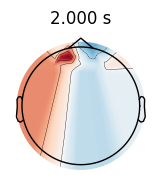

In [537]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

# Calculate the sci index and remove bad channels
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))

raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)
good_channels_idx = mne.pick_channels(raw_haemo.ch_names, raw_haemo.info["ch_names"], exclude=raw_haemo.info["bads"])
raw_haemo.pick(good_channels_idx)

# Filter the data
l_freq = 0.001
h_freq = 0.1

raw_haemo_filtered = raw_haemo.copy()
raw_haemo_filtered.filter(l_freq=l_freq, h_freq=h_freq)

# Get the events from the annotations
events, event_id = mne.events_from_annotations(raw_haemo)
event_id = {'Baseline': 1, 'Test': 2, 'GNG': 3}

# Set epoching parameters
tmin_task, tmax_task = -5, 40  # around the GNG task
window_duration = 2
overlap_duration = 1

hbo = raw_haemo_filtered.copy().pick(picks='hbo')

task_epochs_hbo = mne.Epochs(hbo, events, event_id={'GNG': 3}, tmin=tmin, tmax=tmax, baseline=(None, None), preload=True)

start_time = 0
end_time = start_time + 2
epoch_window = task_epochs_hbo.copy().crop(tmin=start_time, tmax=end_time)
epoch_window
fig = epoch_window.average().plot_topomap(
    times=[2], ch_type='hbo', colorbar=False, 
    extrapolate='head', sensors=False, image_interp="linear"
)

# Figure Configuration
fig.patch.set_alpha(0.0)
fig.suptitle('')  
for ax in fig.axes:
    ax.set_title('')  

# Set figure size and DPI to reach 326x311 pixel dimensions
fig.set_size_inches(2.173, 2.173)  # Set to a square dimension in inches
fig.savefig("topomap_326x326.png", format='png', bbox_inches='tight', pad_inches=0, dpi=150, transparent=True)
plt.close(fig)

In [ ]:
start_time = 0
end_time = start_time + 2

# Crop the epochs to a 2-second window
epoch_window = task_epochs_hbo.copy().crop(tmin=start_time, tmax=end_time)

# Select the first epoch in the windowed data for visualization (no averaging)
fig = epoch_window[0].plot_topomap(
    times=[1], ch_type='hbo', colorbar=False,
    extrapolate='head', sensors=False, image_interp="linear"
)

# Figure Configuration
fig.patch.set_alpha(0.0)  # Transparent background
fig.suptitle('')  # Remove super title
for ax in fig.axes:
    ax.set_title('')  # Remove individual subplot titles

# Set figure size and DPI for 326x311 pixel dimensions
fig.set_size_inches(2.173, 2.173)  # Square dimensions in inches
fig.savefig("topomap_326x326_no_avg.png", format='png', bbox_inches='tight', pad_inches=0, dpi=150, transparent=True)
plt.close(fig)


Initializing animation...
Initializing animation...


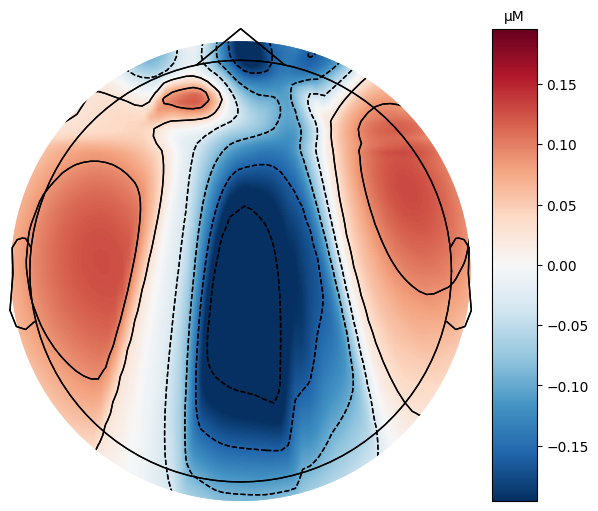

MovieWriter imagemagick unavailable; using Pillow instead.


Initializing animation...


In [529]:
# Ensure times are within the valid range of the evoked object
evoked = epoch_window.average()
valid_times = np.arange(evoked.times[0], evoked.times[-1], 1)  # Step every 1 second within valid range

# Create the animation and get both figure and animation objects
fig, anim = evoked.animate_topomap(
    ch_type='hbo', times=valid_times,  # Use valid times within the evoked range
    frame_rate=5,  # Frames per second
    butterfly=False,  # Disable butterfly plot
    blit=True,  # Enable blitting for efficiency
    show=True,  # Display the animation
    image_interp='cubic',  # Use cubic interpolation for smoother images
    extrapolate='head'  # Extrapolate to the head shape
)

# Save the animation to a file
anim.save("topomap_animation.gif", writer='imagemagick', fps=5)  # Save as GIF
# Alternatively, save as MP4 if preferred and supported
# anim.save("topomap_animation.mp4", writer='ffmpeg', fps=5)


- Calculation Breakdown
  
  1. **Epoch Duration for GNG Task**
     - The eopoch duration is 45 seconds (from `tmin_task=-5` to `tmax_task=40`)
  2. **Windowing Parameters**
     - **Window Duration**: 2 seconds
     - **Overlap Duration**: 1 seconds
  3. **Number of Windows per Epoch**
     - $$\frac{\text{Epoch Duration - Window Duration}}{\text{Overlap Duration}} + 1 = \frac{45-2}{2}+1 = 44 \text{ windows per epoch}$$
  4. **Total Number of Epochs (Repetitions on GNG Task)**: 4 Repetitions 
  5. **Total Image Calculation**
     - Each epoch generates 44 images, and there are 4 epochs in total. So the total number of images for HbO/HbR during the GNG task would be: $44 \text{ images per epoch} \times 4 \text{ epochs} = 176 \text{ images}$

Loading d:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\36. FNIRS-Anxiety\CODE\3. fNIRS\PYTHON\notebook\data_NIRS_Experiment/2023-12-05_004
Reading 0 ... 9435  =      0.000 ...   927.498 secs...


C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_18512\1248249322.py:9: RuntimeWarning: MNE has not been tested with Aurora version 2021.9.0-20-g15526401-dirty
  raw_intensity = mne.io.read_raw_nirx(f'{DATA_DIR}/2023-12-05_004', preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.001 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.00
- Lower transition bandwidth: 0.00 Hz (-6 dB cutoff frequency: 0.00 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 33571 samples (3300.164 s)



C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_18512\1248249322.py:27: RuntimeWarning: filter_length (33571) is longer than the signal (9436), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo_filtered.filter(l_freq=l_freq, h_freq=h_freq)


Used Annotations descriptions: ['1.0', '2.0', '3.0']
Not setting metadata
4 matching events found
Setting baseline interval to [-5.013504, 40.009728] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 459 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Epoch 0: 44 windows
Epoch 1: 44 windows
Epoch 2: 44 windows
Epoch 3: 44 windows


Preparing frames for task hbo animation (Epoch 1): 100%|██████████| 44/44 [00:19<00:00,  2.21it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


Animation saved at topomap_animations\task_hbo_epoch1.gif


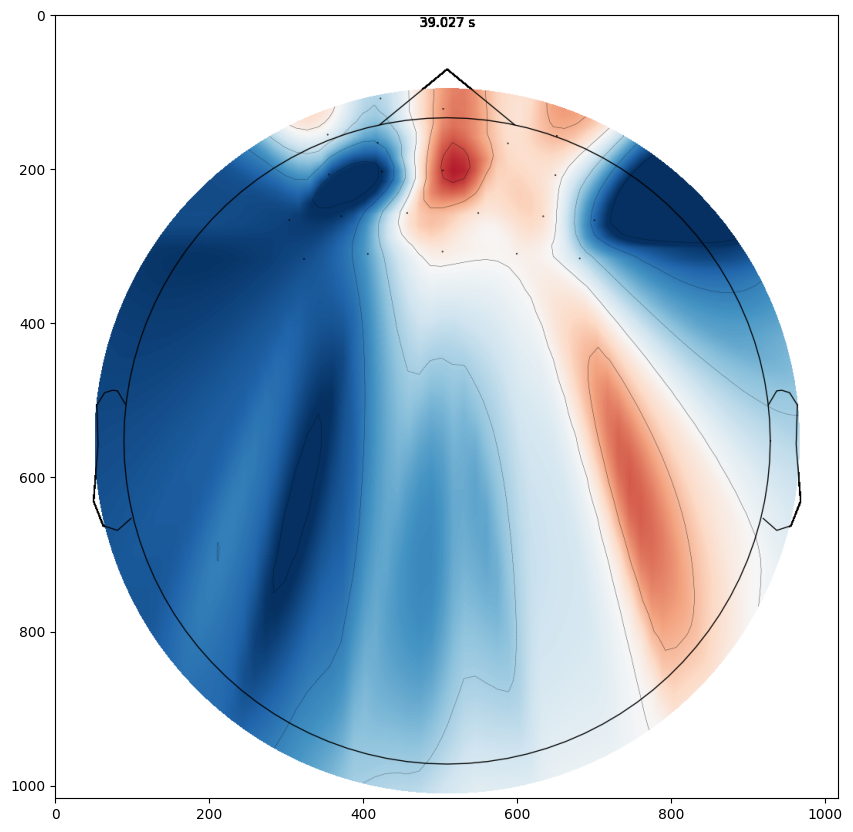

In [11]:
import mne
import numpy as np
from itertools import compress
import os
from sklearn.preprocessing import StandardScaler
from matplotlib.animation import FuncAnimation

# Load the raw optical density data
raw_intensity = mne.io.read_raw_nirx(f'{DATA_DIR}/2023-12-05_004', preload=True)
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

# Calculate scalp coupling index (SCI) and remove bad channels
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))

# Apply the Modified Beer-Lambert Law to convert to hemoglobin concentration
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

# Keep only good channels
good_channels_idx = mne.pick_channels(raw_haemo.ch_names, raw_haemo.info["ch_names"], exclude=raw_haemo.info["bads"])
raw_haemo.pick(good_channels_idx)

# Filter the data
l_freq = 0.001
h_freq = 0.1
raw_haemo_filtered = raw_haemo.copy()
raw_haemo_filtered.filter(l_freq=l_freq, h_freq=h_freq)

# Get the events from the annotations
events, event_id = mne.events_from_annotations(raw_haemo)
event_id = {'Baseline': 1, 'Test': 2, 'GNG': 3}

# Define directories to save images and animations
output_dir = "topomap_images"
animation_dir = "topomap_animations"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(animation_dir, exist_ok=True)

# Set epoching parameters
tmin_task, tmax_task = -5, 40  # around the GNG task
tmin_baseline, tmax_baseline = 10, 40  # stable baseline period
window_duration = 2
overlap_duration = 1

# Function to create sliding windows with 2-second duration and 1-second overlap
def create_sliding_windows(epoch, window_duration, overlap_duration):
    windows = []
    num_windows = int((epoch.tmax - epoch.tmin - window_duration) / overlap_duration) + 1
    for i in range(num_windows):
        start_time = epoch.tmin + i * overlap_duration
        end_time = start_time + window_duration
        window = epoch.copy().crop(tmin=start_time, tmax=end_time)
        windows.append(window)
    return windows

task_epochs_hbo = mne.Epochs(raw_haemo_filtered.copy().pick("hbo"), events, event_id={'GNG': 3}, 
                             tmin=tmin_task, tmax=tmax_task, baseline=(None, None), preload=True)

def standardize_epochs(epochs):
    scaler = StandardScaler()
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
    
    # Reshape data to (n_epochs * n_channels, n_times) for fitting the scaler
    n_epochs, n_channels, n_times = data.shape
    data_reshaped = data.reshape(n_epochs * n_channels, n_times)
    
    # Fit and transform data for Z-score normalization across time dimension
    normalized_data = scaler.fit_transform(data_reshaped.T).T  # Transpose for time-axis normalization, then back
    
    # Reshape back to original dimensions (n_epochs, n_channels, n_times)
    epochs._data = normalized_data.reshape(n_epochs, n_channels, n_times)

# Apply Z-score normalization for task epochs
standardize_epochs(task_epochs_hbo)

task_windows_hbo = []

for i in range(len(task_epochs_hbo)):
    # Extract a single-epoch Epochs object from task_epochs_hbo
    single_epoch = task_epochs_hbo[i:i+1]  # Maintains structure as an Epochs object

    # Generate sliding windows for the current single-epoch Epochs object
    windows = create_sliding_windows(single_epoch, window_duration, overlap_duration)
    print(f"Epoch {i}: {len(windows)} windows")
    
    # Append each window to the main task_windows_hbo list
    task_windows_hbo.extend(windows)

# Save topographic maps as images
def save_topomaps(epochs, hemoglobin_type, condition, output_dir):
    total_images = 0  # To keep track of the total images generated
    
    # Wrapping the outer loop with tqdm for overall progress tracking
    for i, epoch in enumerate(tqdm(epochs, desc=f"Processing {condition} {hemoglobin_type}")):
        # Convert the single-epoch Epochs object to an Evoked object for plotting
        evoked = epoch.average()

        # Select a single representative time point (e.g., middle time point)
        middle_time = evoked.times[len(evoked.times) // 2]

        # Plot the topomap for the selected time point
        fig = evoked.plot_topomap(
            times=[middle_time], ch_type=hemoglobin_type, show=False,
            extrapolate='head', sensors=False, image_interp='nearest',
            colorbar=False
        )
        
        # Figure Configuration
        fig.patch.set_alpha(0.0)  # Set background to transparent
        fig.suptitle('')  # Clear any overarching title
        for ax in fig.axes:
            ax.set_title('')  # Remove titles from each axis
        
        # Set figure size and DPI for 326x311 pixel dimensions
        fig.set_size_inches(2.173, 2.173)  # Set to square dimension in inches
        img_path = os.path.join(output_dir, f"{condition}_{hemoglobin_type}_{i}.png")
        
        # Save the figure with the specific dimensions and transparent background
        fig.savefig(img_path, format='png', bbox_inches='tight', pad_inches=0, dpi=150, transparent=True)
        plt.close(fig)  # Close figure to free memory
        
        # Increment the total image count
        total_images += 1
    
    print(f"Total images generated: {total_images}")
    assert total_images == 176, "Unexpected number of images generated."

# Save HbO topomaps for Task and Baseline using sliding windows
save_topomaps(task_windows_hbo, 'hbo', 'task', output_dir)

def save_single_epoch_animation(epochs, hemoglobin_type, condition, animation_dir, epoch_index=0):
    # Select the sliding windows for the specific epoch
    epoch_start = epoch_index * 44  # Assuming 44 windows per epoch
    epoch_end = epoch_start + 44
    single_epoch_windows = epochs[epoch_start:epoch_end]

    # List to store figures for each window's topomap
    frames = []

    for i, epoch in enumerate(tqdm(single_epoch_windows, desc=f"Preparing frames for {condition} {hemoglobin_type} animation (Epoch {epoch_index + 1})")):
        # Convert each sliding window to an Evoked object
        evoked = epoch.average()

        # Select a single representative time point (e.g., middle time point)
        middle_time = evoked.times[len(evoked.times) // 2]

        # Generate the topomap for this time point
        fig = evoked.plot_topomap(
            times=[middle_time], ch_type=hemoglobin_type, show=False,
            extrapolate='head', sensors=True, image_interp='cubic', 
            colorbar=False
        )

        # Configure figure for transparency and consistent size
        fig.patch.set_alpha(0.0)
        fig.set_size_inches(10.173, 10.173)  # Square dimension for consistency

        # Capture the frame as a NumPy array
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)  # Append to frames list
        plt.close(fig)  # Close figure to free memory

    # Create the animation by sequentially displaying each frame
    fig, ax = plt.subplots(figsize=(10.173, 10.173))
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    # Set up and save the animation
    ani = FuncAnimation(fig, update, frames=frames, blit=True, repeat=True)
    anim_path = os.path.join(animation_dir, f"{condition}_{hemoglobin_type}_epoch{epoch_index + 1}.gif")
    ani.save(anim_path, writer='imagemagick', fps=5)  # Save as GIF
    print(f"Animation saved at {anim_path}")

# Create the animation for the first epoch of HbO during the task condition
save_single_epoch_animation(task_windows_hbo, 'hbo', 'task', animation_dir, epoch_index=0)